In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
from google.colab import drive
import datetime

In [ ]:
# Монтируем наш Google-диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/flowers.zip'
db      = '/content/flowers'

In [ ]:
# Удалить директорию, куда разархивируем датасет
!rm -rf {db}

In [ ]:
# Распаковываем наш архив в пространство Colab
!unzip -q {dataset} -d {db}

In [ ]:
labels = {} # Используем словарь
labels['daisy']     = [1,0,0,0,0]
labels['dandelion'] = [0,1,0,0,0]
labels['rose']      = [0,0,1,0,0]
labels['sunflower'] = [0,0,0,1,0]
labels['tulip'] =     [0,0,0,0,1]

In [ ]:
# Функция проверки формата изображения - альбомный или книжный.
# Возвращаемые значения: True - альбомный, False - книжный
def format_is_album(w: int, h: int):
  return True if w > h else False


# Функция умной обрезки
def smart_trimming(img):
  img_w, img_h = img.size   # Берём размер картинки
  target_size = [130, 110]  # Размер, который мы должны получить в результате

  # Проверка на формат
  if format_is_album(img_w, img_h):
    new_h = target_size[1]                # Делаем высоту основной осью
    new_w = round(new_h / img_h * img_w)  # Считаем ширину
  else:
    new_w = target_size[0]                # Делаем ширину основной осью
    new_h = round(new_w / img_w * img_h)  # Считаем высоту

  # Применяем наши измениния касательно размеров
  img = img.resize((new_w, new_h), Image.ANTIALIAS)

  # Находим центр картинки
  center = [new_w//2, new_h//2]
  # Находим левую верхнюю и правую нижнюю точки для прямоугольной обрезки
  top_left = [center[0] - target_size[0]//2, center[1] - target_size[1]//2]
  bottom_right = [center[0] + target_size[0]//2, center[1] + target_size[1]//2]

  # Обрезаем изображение
  img = img.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

  return img

In [ ]:
image_list = []

for label in labels.keys():
  dir = db+"/flowers/" + label
  flist = os.listdir(db+"/flowers/" + label)
  c = 0
  for f in flist:
    fpath = db+"/flowers/" + label + "/" + f
    image_list.append(fpath)

random.shuffle(image_list)


x_train = []
y_train = []
for fpath in image_list:
  img = Image.open(fpath)
  img = smart_trimming(img)

  image_data = np.array(img)
  x_train.append(image_data)

  label = fpath.split('/')[4]
  y_train.append(labels[label])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(4317, 110, 130, 3)
(4317, 5)


In [ ]:
# задаём batch_size
batch_size = 32 

# Создаем последовательную модель
model = Sequential()
# Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(110, 130, 3), name="bn1"))
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer1"))
# Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer2"))
# Первый слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer1"))
# Слой Dropout
model.add(Dropout(0.2, name="Dropout-layer1"))

# Слой пакетной нормализации
model.add(BatchNormalization(name = "bn2"))
# Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer3"))
# Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer4"))
# Второй слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer2"))
# Слой Dropout
model.add(Dropout(0.2, name="Dropout-layer2"))

# Слой пакетной нормализации
model.add(BatchNormalization(name = "bn3"))
# Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer5"))
# Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer6"))
# Третий слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer3"))
# Слой регуляризации Dropout
model.add(Dropout(0.2, name="Dropout-layer3"))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten(name="flatten"))
# Выходной полносвязный классифицирующий слой
model.add(Dense(5, activation='softmax', name = "labels"))

# Компилируем сеть
#model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

Сохранение весов модели

In [ ]:
# Создание папки, куда будут сохраняться веса
!mkdir weights

weights = 'weights/fl-@@dt@@_{epoch:03d}-{val_loss:.6f}.hdf5'

now = datetime.datetime.now()
dt = now.strftime("%4Y-%2m-%2d_%2H-%2M")
weights = weights.replace("@@dt@@", dt)

# Параметр save_best_only:
# True - сохранять веса на лучшей эпохе. Лучшие веса по отслеживанию в monitor
# False - сохранять веса на каждой эпохе.

model_checkpoint_callback = callbacks.ModelCheckpoint(
   filepath=weights,
   save_weights_only=True,
   monitor='val_loss',
   mode='min',
   save_best_only=False)

Epoch 1/10
115/115 [==============================] - 20s 60ms/step - loss: 1.5832 - accuracy: 0.3906 - val_loss: 1.3280 - val_accuracy: 0.4090
Epoch 2/10
115/115 [==============================] - 5s 45ms/step - loss: 1.0884 - accuracy: 0.5721 - val_loss: 1.2597 - val_accuracy: 0.4506
Epoch 3/10
115/115 [==============================] - 5s 45ms/step - loss: 0.9551 - accuracy: 0.6370 - val_loss: 1.1911 - val_accuracy: 0.5077
Epoch 4/10
115/115 [==============================] - 5s 45ms/step - loss: 0.8676 - accuracy: 0.6667 - val_loss: 1.0574 - val_accuracy: 0.5756
Epoch 5/10
115/115 [==============================] - 5s 46ms/step - loss: 0.7799 - accuracy: 0.7073 - val_loss: 1.0046 - val_accuracy: 0.6111
Epoch 6/10
115/115 [==============================] - 5s 45ms/step - loss: 0.7155 - accuracy: 0.7288 - val_loss: 0.9514 - val_accuracy: 0.6404
Epoch 7/10
115/115 [==============================] - 5s 47ms/step - loss: 0.6686 - accuracy: 0.7503 - val_loss: 1.0647 - val_accuracy: 0.672

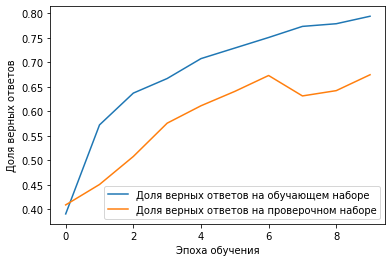

In [ ]:
# Обучаем сеть на наших данных
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[model_checkpoint_callback])

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Сохранение весов 
model.save_weights('flowers.hdf5')

In [ ]:
# Сохранение модели 
model_json = model.to_json()
json_file = open("flowers-model.json", "w")
json_file.write(model_json)
json_file.close()

Сохраненные файлы можно переместить из ОЗУ в постоянную память сохранив их.